# Captcha Bypass

**Team 99**

Pranavbhai Patel

Nicholas Leung

Coden Mercurius

Ravi Singh

**Description**

CAPTCHA, or Completely Automated Public Turing Test to Tell Computers and Humans Apart, is a challenge-response test that determines whether a user is authentic (human) or inauthentic (machine). They require users to authenticate themselves by retyping a character sequence prior to completing a request. This notebook implements a CAPTCHA bypass using deep learning. The team aims to investigate weaknesses and vulnerabilities of the CAPTCHA system.

In [75]:
import torch
import torch.nn as nn
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

## Part 1. Data Processing

The dataset for this model is generated using the following library: https://github.com/lepture/captcha. No additional data augmentation is performed at this time. The code used to generate the dataset is found in the team private repo and is named `dataset_generator.py`.

**Current Dataset Characteristics:**
- Uniform distribution of characters used
- Numerical characters only

The generated dataset is availiable through the team private repo. Upload `dataset.zip` into the root session storage and run the below cell to unzip.

In [ ]:
!unzip /dataset.zip -d /

In [158]:
class CaptchaDataset(Dataset):
  """ Captcha Dataset """

  def __init__(self, directory, character_set):
    self.directory = directory
    self.captchas = os.listdir(directory)
    self.transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    self.character_set = character_set
    self.characters_to_identifier = {}

    for i in range(len(character_set)):
      self.characters_to_identifier.update({ character_set[i]: i })

  def __len__(self):
    # Assumes each file in the dataset directory represents a data sample
    return len(self.captchas)

  def __getitem__(self, index):
    sample_name = self.captchas[index]
    sample_captcha_values = list(sample_name[0:-4]) # Slice s.t. remove png file extension

    # Read the image and represent it as a tensor
    image = io.imread(self.directory + '/' + sample_name)
    image = self.transform(image)

    # Represent each character as an integer identifier
    label = []
    for char in sample_captcha_values:
      label.append(self.characters_to_identifier.get(char))

    return (image, torch.tensor(label))

In [151]:
# Instantiate dataset
character_set = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] # List of characters used in dataset
dataset = CaptchaDataset("/dataset", character_set)

character_frequency = {} # Contains frequency information

# Populate character_frequency
for _, label in dataset:
  for char_identifier in label:
    char = character_set[char_identifier.item()]
    current_value = character_frequency.get(char, None)

    if current_value is None: 
      character_frequency.update({ char : 0 })
    else:
      character_frequency.update({ char : current_value + 1 })

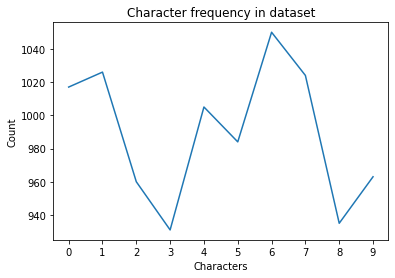

In [149]:
# Dataset visualization

x_values = range(len(character_set))
y_values = []

for char in character_set:
  count = character_frequency.get(char)
  y_values.append(count)

plt.title("Character frequency in dataset")
plt.plot(x_values, y_values)
plt.xlabel("Characters")
plt.ylabel("Count")
plt.xticks(x_values, character_set)
plt.show()


In [159]:
def get_data_loaders(dataset, batch_size):

  training_ratio = 0.7
  validation_ratio = 0.15
  # test_ratio implied

  train_length = int(len(dataset) * training_ratio)
  validation_length = int((len(dataset) - train_length) * (validation_ratio / ( 1 - training_ratio )))
  test_length = len(dataset) - train_length - validation_length
  
  train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_length, validation_length, test_length], torch.Generator().manual_seed(10))

  # REMINDER: Data is not shuffled per epoch, we may want this
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=1)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

  return train_loader, valid_loader, test_loader


In [164]:
train, valid, test = get_data_loaders(dataset, 64)